In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

from pathlib import Path
from collections import Counter

from imblearn.metrics import classification_report_imbalanced
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [153]:
# Load the data
file_path = "c:./Resources/joined_loans_v5_clean.csv"
df = pd.read_csv(file_path)
df.head()

,keyid,loantype,loanbranch,acctnumber,loanid,loandescription,loanpurposecode,loanpurposecodedesc,loanopendate,loanapprovalcode,...,loaninterestrate,loanoriginalbalance,loanpayment,loanpaymentcount,loandelqdays,loancreditscore,debtratio,loantovalue,rbl,loanchargeoffdate
0,3273200,9,16,327320,0,PERSONAL LOAN,25,Personal/Miscellaneous,6/26/2019,1407,...,14.50,1000.00,91.87,12,128,0,0.3630,0.0,4,1.0
1,3256971,5,21,325697,1,2015 DODGE CHARGER,172,Mini of Hawaii,6/22/2019,1437,...,16.25,23399.52,645.81,60,135,530,0.0000,0.0,5,1.0
2,3054723,9,11,305472,3,PERSONAL LOAN,3,Consolidation,6/19/2019,780,...,7.00,18855.64,373.53,60,133,722,0.4139,0.0,1,1.0
3,3111884,9,8,311188,4,DOWNPAYMENT,3,Consolidation,6/17/2019,570,...,15.50,1570.00,145.22,12,133,571,0.3862,0.0,5,1.0
4,3122810,9,1,312281,0,PERSONAL LOAN,3,Consolidation,5/29/2019,780,...,6.00,14536.00,308.23,60,123,720,0.7634,0.0,1,1.0


In [154]:
df.dtypes

keyid                        int64
loantype                     int64
loanbranch                   int64
acctnumber                   int64
loanid                       int64
loandescription             object
loanpurposecode              int64
loanpurposecodedesc         object
loanopendate                object
loanapprovalcode             int64
loanapprovalofficername     object
loaninterestrate           float64
loanoriginalbalance        float64
loanpayment                float64
loanpaymentcount             int64
loandelqdays                 int64
loancreditscore              int64
debtratio                  float64
loantovalue                float64
rbl                          int64
loanchargeoffdate          float64
dtype: object

In [155]:
# Find null values
for column in df.columns:
    print(f'Column {column} has {df[column].isnull().sum()} null values')

Column keyid has 0 null values
Column loantype has 0 null values
Column loanbranch has 0 null values
Column acctnumber has 0 null values
Column loanid has 0 null values
Column loandescription has 0 null values
Column loanpurposecode has 0 null values
Column loanpurposecodedesc has 29 null values
Column loanopendate has 0 null values
Column loanapprovalcode has 0 null values
Column loanapprovalofficername has 28 null values
Column loaninterestrate has 0 null values
Column loanoriginalbalance has 0 null values
Column loanpayment has 0 null values
Column loanpaymentcount has 0 null values
Column loandelqdays has 0 null values
Column loancreditscore has 0 null values
Column debtratio has 0 null values
Column loantovalue has 0 null values
Column rbl has 0 null values
Column loanchargeoffdate has 21333 null values


In [156]:
# Create a new DataFrame that removes useless columns.

loans_df = df.drop(columns=["acctnumber", 
                            "loanid",
                            "loandescription",
                            "loanpurposecodedesc",
                            "loanopendate",
                            "loanapprovalofficername",
                            "loandelqdays"
                           ])
loans_df

,keyid,loantype,loanbranch,loanpurposecode,loanapprovalcode,loaninterestrate,loanoriginalbalance,loanpayment,loanpaymentcount,loancreditscore,debtratio,loantovalue,rbl,loanchargeoffdate
0,3273200,9,16,25,1407,14.50,1000.00,91.87,12,0,0.3630,0.0000,4,1.0
1,3256971,5,21,172,1437,16.25,23399.52,645.81,60,530,0.0000,0.0000,5,1.0
2,3054723,9,11,3,780,7.00,18855.64,373.53,60,722,0.4139,0.0000,1,1.0
3,3111884,9,8,3,570,15.50,1570.00,145.22,12,571,0.3862,0.0000,5,1.0
4,3122810,9,1,3,780,6.00,14536.00,308.23,60,720,0.7634,0.0000,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22503,2859041,9,7,90,585,5.50,40180.00,592.87,84,843,0.3294,0.0000,1,NaN
22504,259490,9,1,7,780,4.50,20000.00,373.02,60,772,0.3633,0.0000,1,NaN
22505,1165586,5,7,13,780,3.25,18239.00,362.72,60,734,0.3455,1.0287,1,NaN
22506,1736283,12,4,40,570,6.75,25000.00,259.00,0,791,0.3218,0.0000,1,NaN


In [157]:
# convert loanchargeoffdate to 0 or 1
loans_df['loanchargeoffdate'] = loans_df['loanchargeoffdate'].replace([np.nan], 0)
loans_df

,keyid,loantype,loanbranch,loanpurposecode,loanapprovalcode,loaninterestrate,loanoriginalbalance,loanpayment,loanpaymentcount,loancreditscore,debtratio,loantovalue,rbl,loanchargeoffdate
0,3273200,9,16,25,1407,14.50,1000.00,91.87,12,0,0.3630,0.0000,4,1.0
1,3256971,5,21,172,1437,16.25,23399.52,645.81,60,530,0.0000,0.0000,5,1.0
2,3054723,9,11,3,780,7.00,18855.64,373.53,60,722,0.4139,0.0000,1,1.0
3,3111884,9,8,3,570,15.50,1570.00,145.22,12,571,0.3862,0.0000,5,1.0
4,3122810,9,1,3,780,6.00,14536.00,308.23,60,720,0.7634,0.0000,1,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22503,2859041,9,7,90,585,5.50,40180.00,592.87,84,843,0.3294,0.0000,1,0.0
22504,259490,9,1,7,780,4.50,20000.00,373.02,60,772,0.3633,0.0000,1,0.0
22505,1165586,5,7,13,780,3.25,18239.00,362.72,60,734,0.3455,1.0287,1,0.0
22506,1736283,12,4,40,570,6.75,25000.00,259.00,0,791,0.3218,0.0000,1,0.0


In [158]:
# Delete rows where debtratio = 0.  debtratio believed to be significant to prediction.
loans_df = loans_df[loans_df.debtratio != 0]
loans_df

,keyid,loantype,loanbranch,loanpurposecode,loanapprovalcode,loaninterestrate,loanoriginalbalance,loanpayment,loanpaymentcount,loancreditscore,debtratio,loantovalue,rbl,loanchargeoffdate
0,3273200,9,16,25,1407,14.50,1000.00,91.87,12,0,0.3630,0.0000,4,1.0
2,3054723,9,11,3,780,7.00,18855.64,373.53,60,722,0.4139,0.0000,1,1.0
3,3111884,9,8,3,570,15.50,1570.00,145.22,12,571,0.3862,0.0000,5,1.0
4,3122810,9,1,3,780,6.00,14536.00,308.23,60,720,0.7634,0.0000,1,1.0
5,336724,9,5,3,166,8.25,18048.20,369.26,60,691,0.4380,0.0000,2,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22503,2859041,9,7,90,585,5.50,40180.00,592.87,84,843,0.3294,0.0000,1,0.0
22504,259490,9,1,7,780,4.50,20000.00,373.02,60,772,0.3633,0.0000,1,0.0
22505,1165586,5,7,13,780,3.25,18239.00,362.72,60,734,0.3455,1.0287,1,0.0
22506,1736283,12,4,40,570,6.75,25000.00,259.00,0,791,0.3218,0.0000,1,0.0


In [159]:
loans_df["loanchargeoffdate"].value_counts()

0.0    15912
1.0      731
Name: loanchargeoffdate, dtype: int64

In [160]:
loans_df["loantype"].value_counts()

9     11192
5      2159
12     2136
1       673
11      483
Name: loantype, dtype: int64

In [161]:
loantype_df = pd.DataFrame(loans_df["loantype"].value_counts()).reset_index()
loantype_df

,index,loantype
0,9,11192
1,5,2159
2,12,2136
3,1,673
4,11,483


In [162]:
import plotly.express as px

fig = px.bar(loantype_df, x='index', y='loantype')
fig.show()

# Bin

In [163]:
# Loan Purpose Code
loanpurposecode_cts = loans_df["loanpurposecode"].value_counts()
loanpurposecode_cts

3      5081
25     3699
40     2130
13     1540
2      1012
       ... 
94        1
174       1
915       1
162       1
161       1
Name: loanpurposecode, Length: 81, dtype: int64

<AxesSubplot:ylabel='Density'>

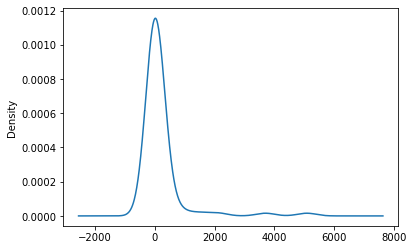

In [164]:
# Visualize the value counts of loanapprovalcode
loanpurposecode_cts.plot.density()

In [165]:
# Bin loans_df.loanpurposecode_cts < 275
replace_loanpurposecode = list(loanpurposecode_cts[loanpurposecode_cts < 275].index)

# Replace in dataframe
for loan in replace_loanpurposecode:
    loans_df.loanpurposecode = loans_df.loanpurposecode.replace(loan,9999)
    
# Verify binning was successful
loans_df.loanpurposecode.value_counts()

3       5081
25      3699
40      2130
13      1540
9999    1296
2       1012
23       681
43       470
14       413
17       321
Name: loanpurposecode, dtype: int64

In [166]:
# Loan Approval Code
loanapprovalcode_cts = loans_df["loanapprovalcode"].value_counts()
loanapprovalcode_cts

780     5253
1437    3090
585     1801
570     1214
47       993
1017     769
55       747
1407     703
1916     687
166      346
1176     336
1090     270
1462     179
341      113
241       90
61        22
426       12
1841       4
1795       3
201        2
284        1
20         1
1098       1
1770       1
775        1
84         1
1044       1
24         1
0          1
Name: loanapprovalcode, dtype: int64

In [167]:
# Bin loans_df.loanapprovalcode < 100
replace_loanapprovalcode = list(loanapprovalcode_cts[loanapprovalcode_cts < 100].index)

# Replace in dataframe
for loan in replace_loanapprovalcode:
    loans_df.loanapprovalcode = loans_df.loanapprovalcode.replace(loan,9999)
    
# Verify binning was successful
loans_df.loanapprovalcode.value_counts()

780     5253
1437    3090
585     1801
570     1214
47       993
1017     769
55       747
1407     703
1916     687
166      346
1176     336
1090     270
1462     179
9999     142
341      113
Name: loanapprovalcode, dtype: int64

In [168]:
loans_df.dtypes

keyid                    int64
loantype                 int64
loanbranch               int64
loanpurposecode          int64
loanapprovalcode         int64
loaninterestrate       float64
loanoriginalbalance    float64
loanpayment            float64
loanpaymentcount         int64
loancreditscore          int64
debtratio              float64
loantovalue            float64
rbl                      int64
loanchargeoffdate      float64
dtype: object

<AxesSubplot:ylabel='Density'>

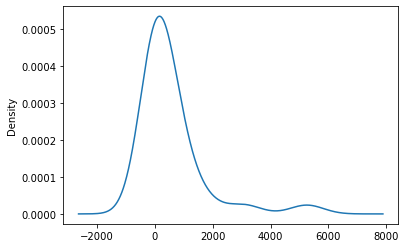

In [169]:
# Visualize the value counts of loanapprovalcode
loanapprovalcode_cts.plot.density()

In [170]:
loans_df.columns.tolist()

['keyid',
 'loantype',
 'loanbranch',
 'loanpurposecode',
 'loanapprovalcode',
 'loaninterestrate',
 'loanoriginalbalance',
 'loanpayment',
 'loanpaymentcount',
 'loancreditscore',
 'debtratio',
 'loantovalue',
 'rbl',
 'loanchargeoffdate']

In [ ]:
# Scale

In [171]:
loans_df.dtypes

keyid                    int64
loantype                 int64
loanbranch               int64
loanpurposecode          int64
loanapprovalcode         int64
loaninterestrate       float64
loanoriginalbalance    float64
loanpayment            float64
loanpaymentcount         int64
loancreditscore          int64
debtratio              float64
loantovalue            float64
rbl                      int64
loanchargeoffdate      float64
dtype: object

## Split the Data into Training and Testing

In [145]:
X = loans_df[['loantype',
             'loanbranch',
             'loanpurposecode',
             'loanapprovalcode',
             'loaninterestrate',
             'loanoriginalbalance',
             'loanpayment',
             'loanpaymentcount',
             'loancreditscore',
             'debtratio',
             'loantovalue',
             'rbl']]
y = loans_df["loanchargeoffdate"]

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=1)
scaler = StandardScaler().fit(X_train)

In [147]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [148]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()
classifier

LogisticRegression()

In [149]:
classifier.fit(X_train_scaled, y_train)

LogisticRegression()

In [150]:
print(f"Training Data Score: {classifier.score(X_train_scaled, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test_scaled, y_test)}")

Training Data Score: 0.9566621601321916
Testing Data Score: 0.9534394713127066


In [152]:
# List the features sorted in descending order by feature importance

sorted(zip(loans_df.feature_importances_, X.columns), reverse=True)

AttributeError: 'DataFrame' object has no attribute 'feature_importances_'

In [172]:
# Resample the training data with the BalancedRandomForestClassifier
# YOUR CODE HERE
# Create a random forest classifier.
loan_model = BalancedRandomForestClassifier(n_estimators=128, random_state=1) 

# Fitting the model
loan_model = loan_model.fit(X_train, y_train)

# Making predictions using the testing data.
predictions = loan_model.predict(X_test)


In [173]:
predictions

array([0., 0., 0., ..., 0., 1., 0.])

In [174]:
# Calculated the balanced accuracy score
# YOUR CODE HERE
from sklearn.metrics import balanced_accuracy_score

balanced_accuracy_score(y_test, predictions)

0.6538986117039657

In [175]:
# Display the confusion matrix
# YOUR CODE HERE
from sklearn.metrics import confusion_matrix

predictions = loan_model.predict(X_test)
confusion_matrix(y_test, predictions)

array([[1837, 1337],
       [  42,  113]], dtype=int64)

In [176]:
# Print the imbalanced classification report
# YOUR CODE HERE
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, predictions))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.98      0.58      0.73      0.73      0.65      0.42      3174
        1.0       0.08      0.73      0.58      0.14      0.65      0.43       155

avg / total       0.94      0.59      0.72      0.70      0.65      0.42      3329



In [177]:
# List the features sorted in descending order by feature importance
# YOUR CODE HERE
# loans_binary_encoded.columns.tolist()

sorted(zip(loan_model.feature_importances_, X.columns), reverse=True)

[(0.17696072170044166, 'loancreditscore'),
 (0.14032748142461587, 'debtratio'),
 (0.13254811424319413, 'loanpayment'),
 (0.11574658996972959, 'loaninterestrate'),
 (0.11180387489698716, 'loanoriginalbalance'),
 (0.08857688296817992, 'loanbranch'),
 (0.06937764149421974, 'loanapprovalcode'),
 (0.04563046981714756, 'loanpurposecode'),
 (0.04170070950811137, 'loanpaymentcount'),
 (0.040942358719832754, 'rbl'),
 (0.01994724647956655, 'loantovalue'),
 (0.01643790877797385, 'loantype')]

## Spare code

In [39]:
# export 
df.to_csv(r"c:./csv_exports/file_name.csv", header = True)

In [ ]:
# List the features sorted in descending order by feature importance
# YOUR CODE HERE
# loans_binary_encoded.columns.tolist()

sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)